In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
newData = newData.drop_duplicates()
newData = newData.asfreq('H')
newData = newData.fillna(method='ffill')


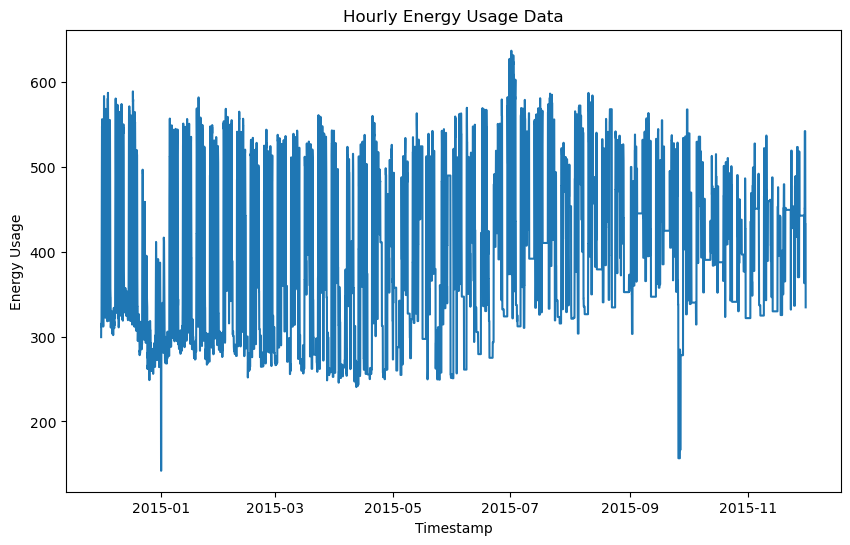

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(newData.index, newData['Office_Garman'])
plt.xlabel('Timestamp')
plt.ylabel('Energy Usage')
plt.title('Hourly Energy Usage Data')
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))

check_stationarity(newData['Office_Garman'])


ADF Statistic: -11.661
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


p-value is less than 0.05, hence the data is stationary. No need to apply differencing. The value of 'd' is determined by how many times the differencing was applied, which is zero in this case. 

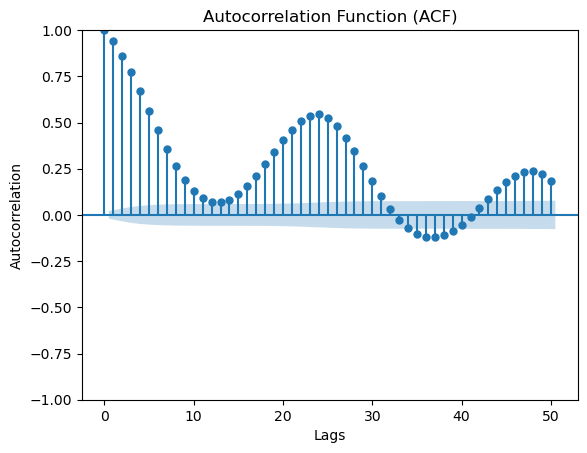

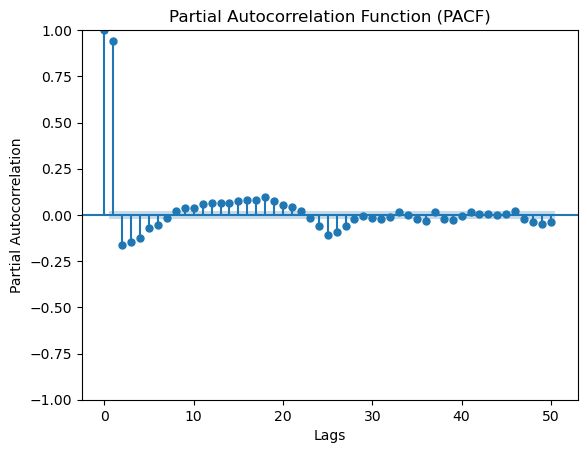

In [5]:
# determining the order of AR and MA
plot_acf(newData, lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(newData, lags=50)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


The first 12 lags are significant in the ACF plot and the first lag is significant in PACF plot. Hence the 'p' is determined as 12 and 'q' is determined as 1. 'd' is zero, from the previous step. 

In [6]:
# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = newData.loc[:split_date]
test = newData.loc[split_date:]

In [7]:
model = ARIMA(train['Office_Garman'], order=(12, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          Office_Garman   No. Observations:                 7296
Model:                ARIMA(12, 0, 1)   Log Likelihood              -35185.251
Date:                Tue, 30 May 2023   AIC                          70400.503
Time:                        14:13:32   BIC                          70503.929
Sample:                    12-01-2014   HQIC                         70436.068
                         - 09-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        386.7564      8.527     45.358      0.000     370.044     403.468
ar.L1          1.8434      0.027     68.091      0.000       1.790       1.896
ar.L2         -0.8431      0.039    -21.684      0.0

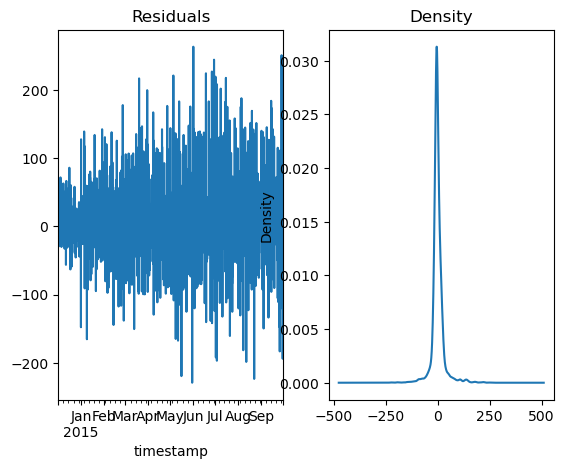

In [8]:
# Evaluating the residuals
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [9]:
# Make predictions on the test set
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# Display the predictions
print(predictions)

2015-09-30 00:00:00    309.024224
2015-09-30 01:00:00    310.618802
2015-09-30 02:00:00    313.507733
2015-09-30 03:00:00    325.280009
2015-09-30 04:00:00    327.453275
                          ...    
2015-11-30 19:00:00    386.756388
2015-11-30 20:00:00    386.756388
2015-11-30 21:00:00    386.756388
2015-11-30 22:00:00    386.756388
2015-11-30 23:00:00    386.756388
Freq: H, Name: predicted_mean, Length: 1488, dtype: float64


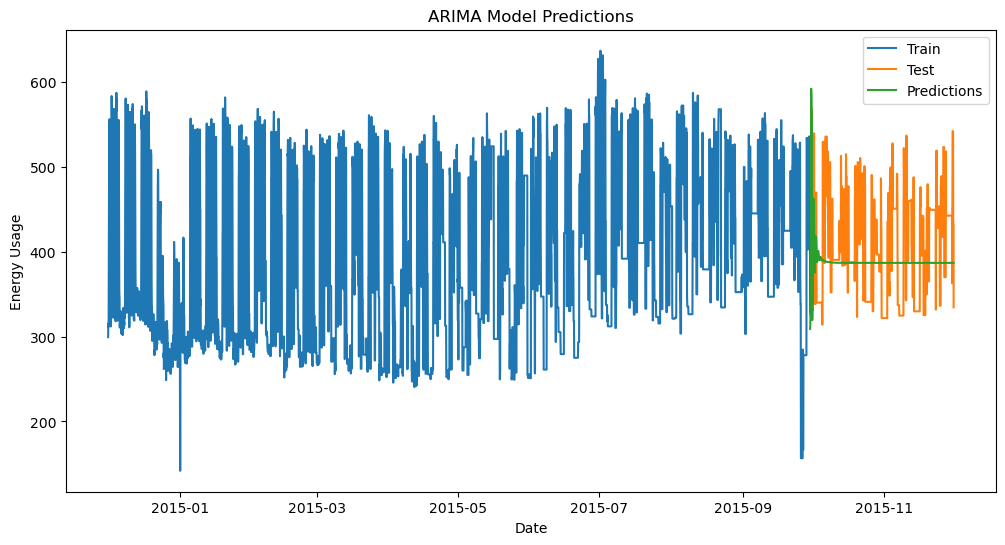

In [10]:
# Plotting the actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(predictions.index, predictions.values, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

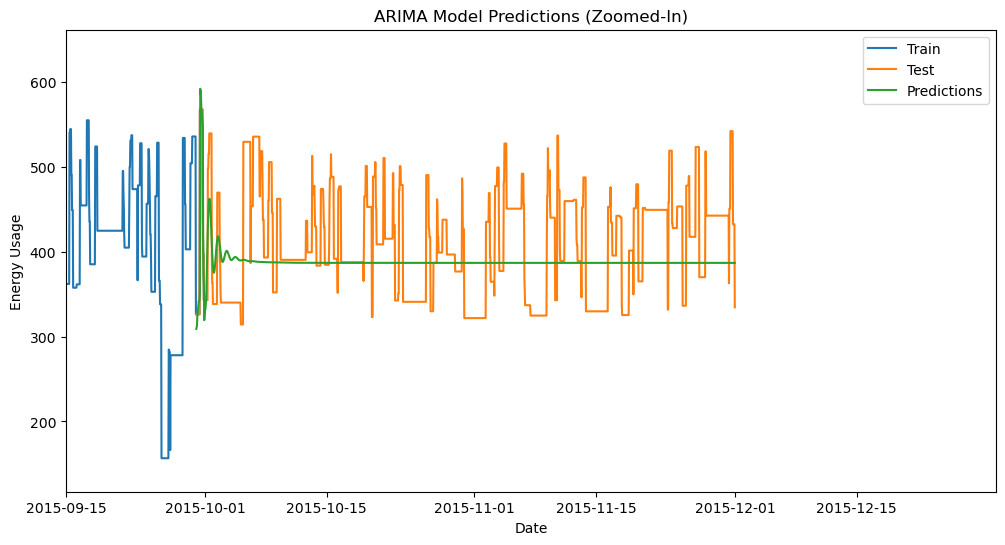

In [11]:
# Define the date range for zooming in
zoom_start_date = pd.to_datetime('2015-09-15')
zoom_end_date = pd.to_datetime('2015-12-31')

# Plotting the zoomed-in section
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(predictions.index, predictions.values, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('ARIMA Model Predictions (Zoomed-In)')
plt.xlim(zoom_start_date, zoom_end_date)  # Set the x-axis limits
plt.legend()
plt.show()


In [12]:
# Evaluating the model predictions
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 51.5988965595702
mape - manual: 0.12322396754690534
rmse - manual: 62.92984359467853


In [13]:
import pmdarima as pm

# Perform grid search to find best p, d, q, P, D, Q values
model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # Use the ADF test to determine stationarity
                      seasonal=True,    # Enable seasonality
                      m=24,             # Set the seasonal frequency
                      trace=True)       # Print detailed information

# Print the selected model's parameters
print(model.order)
print(model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=84301.021, Time=31.29 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=87022.163, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=70794.131, Time=20.11 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=78378.832, Time=15.85 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=108063.291, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=71276.278, Time=0.32 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=70696.525, Time=123.87 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=182.53 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=40.68 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=84593.089, Time=117.53 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=70653.321, Time=135.09 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=70728.433, Time=33.66 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=70587.031, Time=226.02 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=45.57 sec
 ARIMA

/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(1,0,2)[24]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
            

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create the SARIMAX model with the desired order and seasonal_order
model = SARIMAX(train, order=(2, 0, 0), seasonal_order=(1, 0, 2, 24))

# Fit the SARIMAX model with the selected parameters and initial values
fitted_model = model.fit(start_params=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
fitted_model = model.fit(start_params=initial_params, method='Newton')

# Print the model summary
print(fitted_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94505D+05    |proj g|=  1.86253D+06


 This problem is unconstrained.



At iterate    5    f=  4.78436D+02    |proj g|=  6.05612D+02

At iterate   10    f=  5.25394D+01    |proj g|=  2.77536D+01

At iterate   15    f=  1.01065D+01    |proj g|=  3.88109D+00

At iterate   20    f=  5.10125D+00    |proj g|=  2.46625D-01

At iterate   25    f=  4.79589D+00    |proj g|=  6.52508D-03

At iterate   30    f=  4.79501D+00    |proj g|=  3.58662D-03

At iterate   35    f=  4.78804D+00    |proj g|=  8.55619D-03

At iterate   40    f=  4.78599D+00    |proj g|=  2.94041D-03

At iterate   45    f=  4.78344D+00    |proj g|=  2.69879D-02


/Users/Ubaid/Library/CloudStorage/OneDrive-UniversidadedoAlgarve/analysis-dir/ts-data/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.78107D+00    |proj g|=  6.96188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   6.962D-03   4.781D+00
  F =   4.7810671242391889     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


NameError: name 'initial_params' is not defined

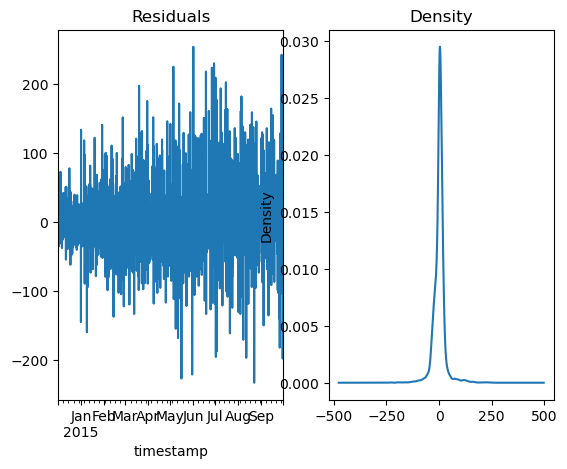

In [15]:
# Evaluating the residuals
residuals = fitted_model.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [16]:
# Make predictions on the test set
predictions = fitted_model.predict(start=test.index[0], end=test.index[-1])

# Display the predictions
print(predictions)

2015-09-30 00:00:00    324.758792
2015-09-30 01:00:00    330.459051
2015-09-30 02:00:00    328.380478
2015-09-30 03:00:00    328.385191
2015-09-30 04:00:00    328.495185
                          ...    
2015-11-30 19:00:00    380.761789
2015-11-30 20:00:00    371.451258
2015-11-30 21:00:00    364.011149
2015-11-30 22:00:00    363.373975
2015-11-30 23:00:00    357.482745
Freq: H, Name: predicted_mean, Length: 1488, dtype: float64


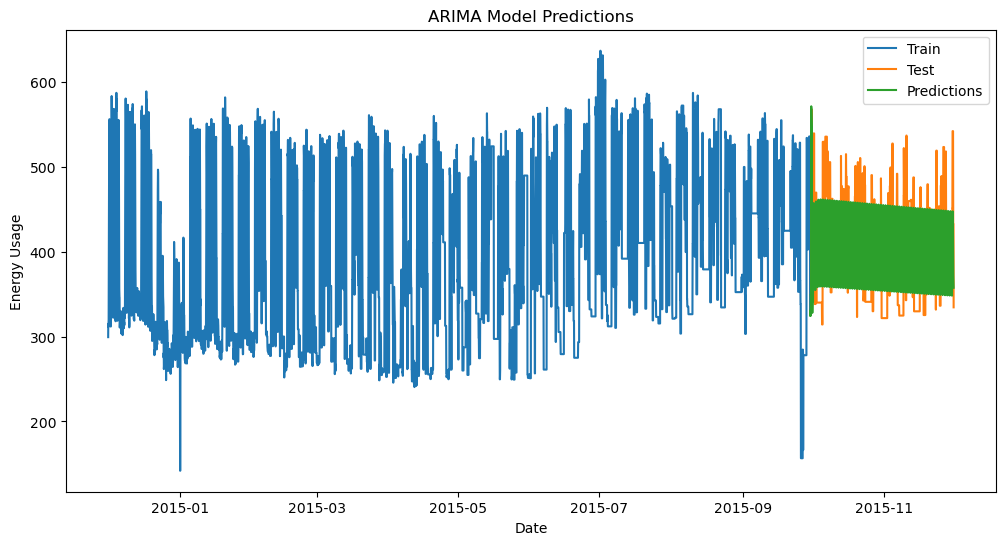

In [17]:
# Plotting the actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(predictions.index, predictions.values, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

In [18]:
#Evaluating the model predictions
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 47.981108214635455
mape - manual: 0.11778655965498282
rmse - manual: 59.47980466248091
